<a href="https://colab.research.google.com/github/byuill/MRSWAT/blob/main/Build_MRSWAT_BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install noaa-coops

from datetime import datetime, timedelta, timezone
import requests
import pandas as pd
from datetime import datetime, timedelta
import io
import time
import matplotlib.pyplot as plt
from noaa_coops import Station

# --- Configuration ---
STATION_ID = "8760922"  # Pilots Station East, SW Pass, LA
DATUM = "MLLW"          # Options: MLLW, NAVD, MSL
UNITS = "english"        # Options: english, metric
TIME_ZONE = "lst_ldt"       # Options: gmt, lst_ldt (local)
today_str = datetime.now().strftime('%Y%m%d')
Days_Back = 180
MLLW2NAVD88 = -0.68 #ft

Fetching data: 20250816 to 20250915...
Fetching data: 20250916 to 20251016...
Fetching data: 20251017 to 20251116...
Fetching data: 20251117 to 20251217...
Fetching data: 20251218 to 20260117...
Fetching data: 20260118 to 20260212...

Success! Downloaded 43295 records.


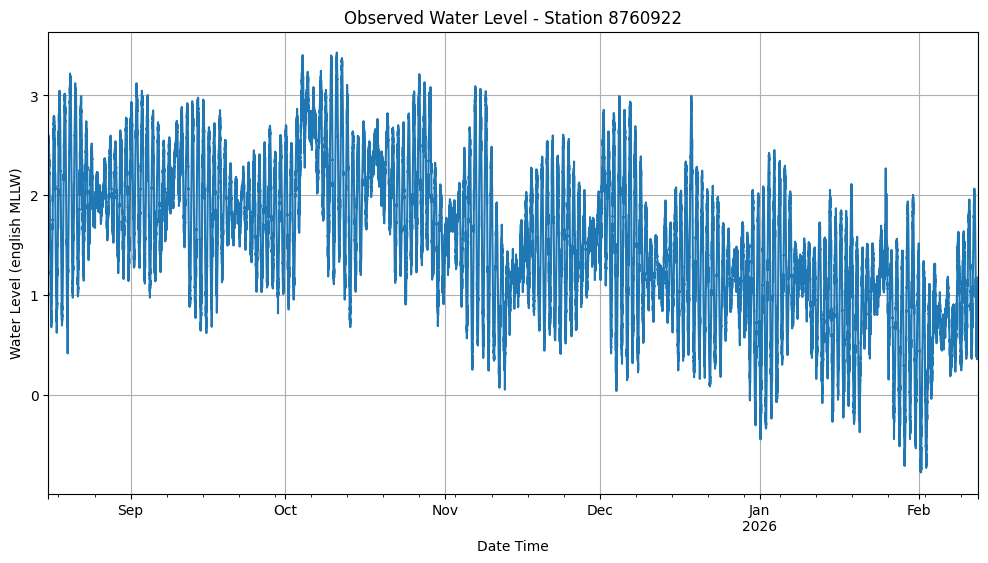

In [ ]:


def get_noaa_data(days_back=Days_Back):
    """
    Fetches observed water levels for the last N days.
    Handles NOAA's 31-day data limit by chunking requests.
    """
    base_url = "https://api.tidesandcurrents.noaa.gov/api/prod/datagetter"

    # Use timezone-aware UTC correctly
    end_date = datetime.now(timezone.utc)
    start_date = end_date - timedelta(days=days_back)

    all_data = []

    # Loop through time range in 30-day chunks
    current_start = start_date
    while current_start < end_date:
        current_end = min(current_start + timedelta(days=30), end_date)

        # Format dates as YYYYMMDD
        begin_str = current_start.strftime("%Y%m%d")
        end_str = current_end.strftime("%Y%m%d")

        print(f"Fetching data: {begin_str} to {end_str}...")

        params = {
            "begin_date": begin_str,
            "end_date": end_str,
            "station": STATION_ID,
            "product": "water_level",
            "datum": DATUM,
            "units": UNITS,
            "time_zone": TIME_ZONE,
            "format": "csv",
            "application": "Python_Script"
        }

        try:
            response = requests.get(base_url, params=params)
            if response.status_code == 200 and "Error" not in response.text:
                chunk_df = pd.read_csv(io.StringIO(response.text))
                # Clean column names immediately to prevent KeyErrors
                chunk_df.columns = chunk_df.columns.str.strip()
                all_data.append(chunk_df)
            else:
                print(f"  Warning: No data or error for {begin_str}-{end_str}")
        except Exception as e:
            print(f"  Error: {e}")

        time.sleep(0.5)
        current_start = current_end + timedelta(days=1)

    if all_data:
        final_df = pd.concat(all_data, ignore_index=True)
        final_df['Date Time'] = pd.to_datetime(final_df['Date Time'])
        final_df.set_index('Date Time', inplace=True)
        return final_df
    else:
        return None

if __name__ == "__main__":
    df = get_noaa_data(days_back=180)

    if df is not None:
        print(f"\nSuccess! Downloaded {len(df)} records.")

        # Optional: Save to CSV
        filename = f"NOAA_{STATION_ID}_Observed_{DATUM}.csv"
        df.to_csv(filename)

        # Plotting - with error handling for column names
        import matplotlib.pyplot as plt
        target_col = 'Water Level' if 'Water Level' in df.columns else df.columns[0]
        df[target_col].plot(figsize=(12, 6), title=f"Observed Water Level - Station {STATION_ID}")
        plt.ylabel(f"Water Level ({UNITS} {DATUM})")
        plt.grid(True)
        plt.show()
    else:
        print("Failed to retrieve data.")

Retrieved 7191 prediction records for Station 8760922.
Date Range: 20260213 to 20260315
                         v
t                         
2026-02-13 00:00:00 -0.059
2026-02-13 00:06:00 -0.080
2026-02-13 00:12:00 -0.101
2026-02-13 00:18:00 -0.121
2026-02-13 00:24:00 -0.141


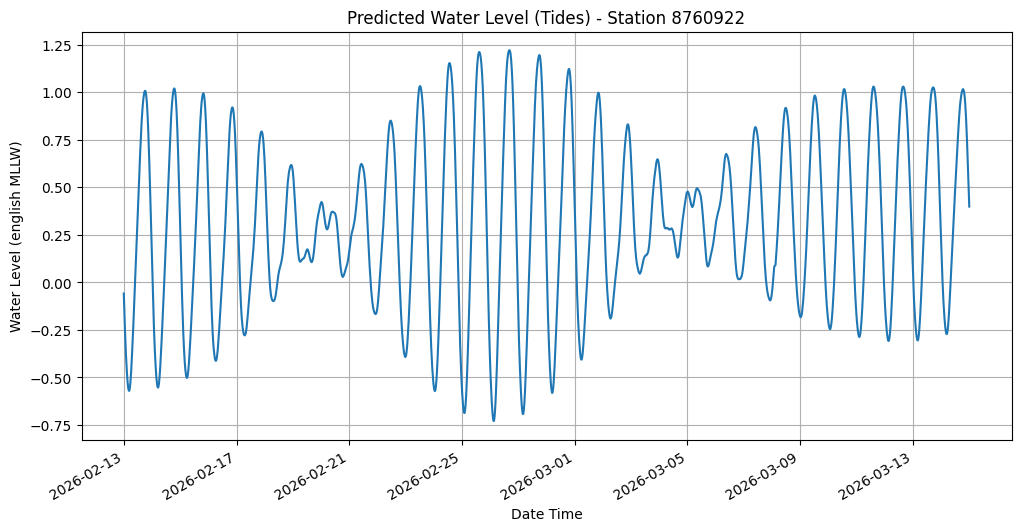

In [ ]:

try:
    # Calculate dates: start is tomorrow, end is 30 days from now
    now = datetime.now()
    prediction_begin_str = (now + timedelta(days=1)).strftime('%Y%m%d')
    prediction_end_str = (now + timedelta(days=31)).strftime('%Y%m%d')

    # Define the station using the global variable
    station = Station(id=STATION_ID)

    # Fetch predicted water levels using the calculated date range
    df_predictions = station.get_data(
        begin_date=prediction_begin_str,
        end_date=prediction_end_str,
        product="predictions",
        datum=DATUM,
        units=UNITS,
        time_zone=TIME_ZONE
    )

    print(f"Retrieved {len(df_predictions)} prediction records for Station {STATION_ID}.")
    print(f"Date Range: {prediction_begin_str} to {prediction_end_str}")
    print(df_predictions.head())

    # Plotting the predictions
    plt.figure(figsize=(12, 6))
    # Predictions usually come in a column named 'v'
    target_col = 'v' if 'v' in df_predictions.columns else df_predictions.columns[0]
    df_predictions[target_col].plot(title=f"Predicted Water Level (Tides) - Station {STATION_ID}")
    plt.ylabel(f"Water Level ({UNITS} {DATUM})")
    plt.xlabel("Date Time")
    plt.grid(True)
    plt.show()

except Exception as e:
    print(f"Could not retrieve or plot predictions for station {STATION_ID}.")
    print(f"Error detail: {e}")

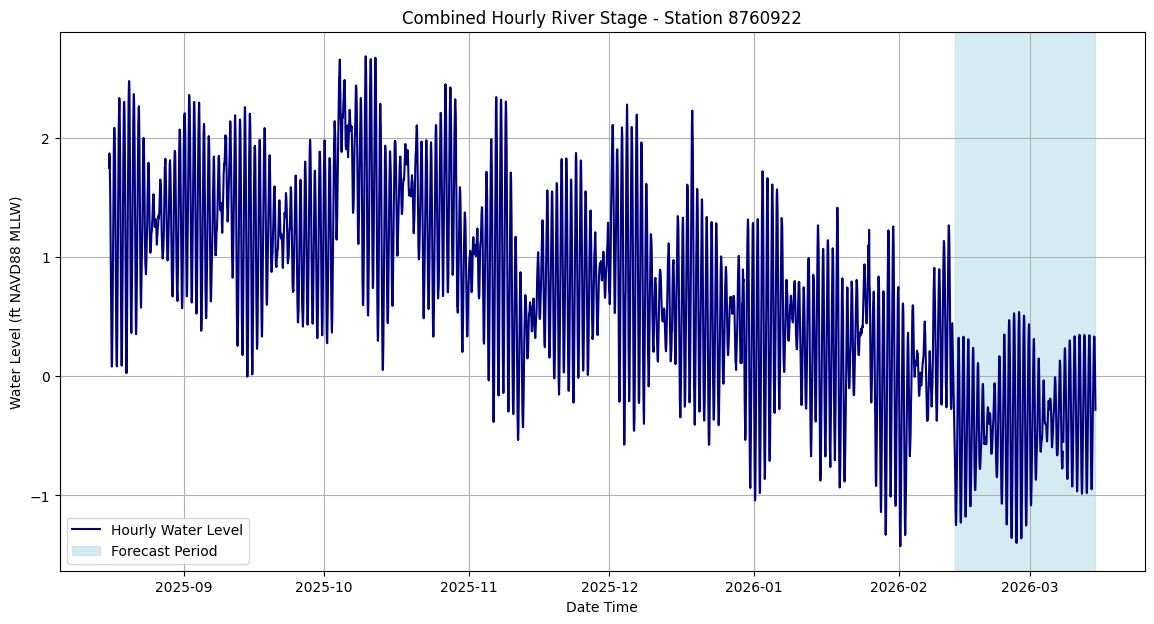

In [ ]:
# Identify the correct value columns
obs_col = 'Water Level' if 'Water Level' in df.columns else df.columns[0]
pred_col = 'v' if 'v' in df_predictions.columns else df_predictions.columns[0]

# Resample observed data to hourly frequency
obs_hourly = df[[obs_col]].resample('1h').mean()

# Prepare and resample predicted data to hourly frequency
# Ensure the index is in datetime format
df_predictions.index = pd.to_datetime(df_predictions.index)
pred_hourly = df_predictions[[pred_col]].rename(columns={pred_col: obs_col}).resample('1h').mean()

# Combine the dataframes CONVERT to NAVD88
combined_df = pd.concat([obs_hourly, pred_hourly]).sort_index() + MLLW2NAVD88
UNITS ="ft NAVD88"
# Plot the combined data
plt.figure(figsize=(14, 7))
plt.plot(combined_df.index, combined_df[obs_col], label='Hourly Water Level', color='navy')

# Color the background for the forecasted period
if not pred_hourly.empty:
    plt.axvspan(pred_hourly.index.min(), pred_hourly.index.max(), color='lightblue', alpha=0.5, label='Forecast Period')

plt.title(f"Combined Hourly River Stage - Station {STATION_ID}")
plt.ylabel(f"Water Level ({UNITS} {DATUM})")
plt.xlabel("Date Time")
plt.legend()
plt.grid(True)
plt.show()

Fetching USGS Instantaneous data for site 07374000...
Downloaded 17264 records.
                     Discharge_cfs
Date                              
2026-02-12 14:15:00       233000.0
2026-02-12 14:30:00       232000.0
2026-02-12 14:45:00       232000.0
2026-02-12 15:00:00       232000.0
2026-02-12 15:15:00       232000.0


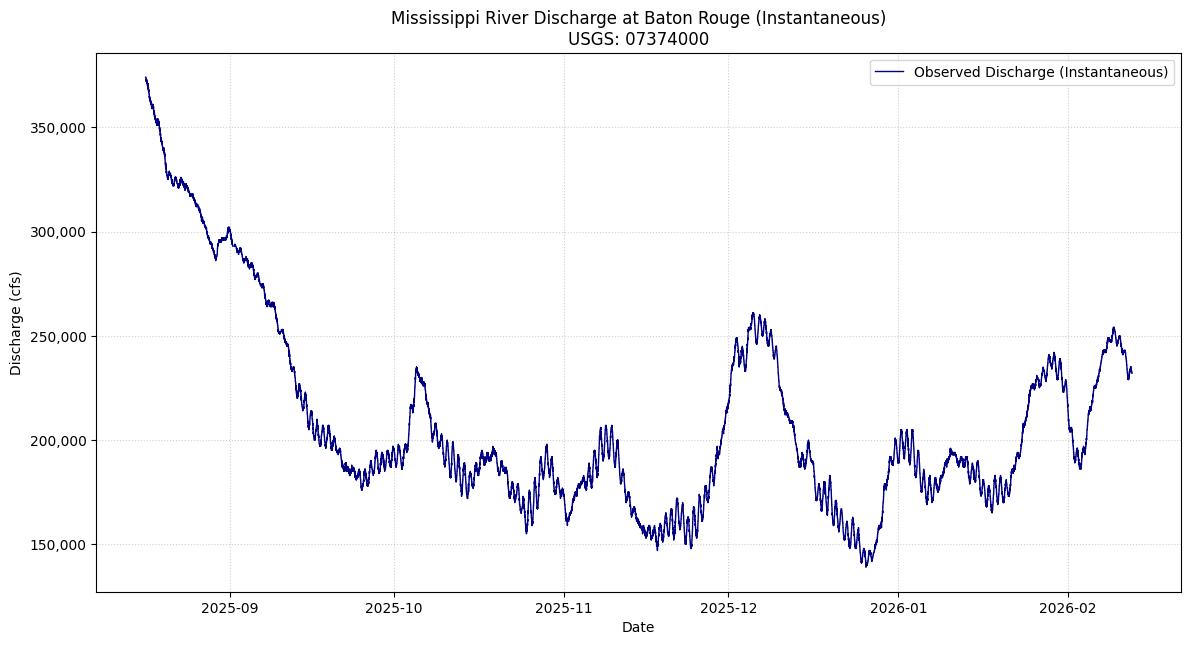

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# --- Configuration ---
USGS_STATION_ID = "07374000"  # Mississippi River at Baton Rouge, LA

def get_usgs_instantaneous_discharge(site_id, days_back):
    """
    Fetches instantaneous discharge (00060) from USGS NWIS.
    Using 'iv' (Instantaneous Value) service.
    """
    url = "https://waterservices.usgs.gov/nwis/iv/?format=json"

    # efficient way to get recent data using ISO period format
    params = {
        "sites": site_id,
        "period": f"P{days_back}D",  # P<days>D format
        "parameterCd": "00060",       # Discharge
        "siteStatus": "all"
    }

    try:
        print(f"Fetching USGS Instantaneous data for site {site_id}...")
        response = requests.get(url, params=params)
        response.raise_for_status()
        data = response.json()

        ts_data = []
        if 'value' in data and 'timeSeries' in data['value'] and len(data['value']['timeSeries']) > 0:
            # Navigate JSON
            values = data['value']['timeSeries'][0]['values'][0]['value']
            for item in values:
                ts_data.append({
                    'Date': pd.to_datetime(item['dateTime'], utc=True),
                    'Discharge_cfs': float(item['value'])
                })

            df = pd.DataFrame(ts_data)
            if not df.empty:
                df.set_index('Date', inplace=True)
                # Convert to local time or keep UTC? Let's remove TZ for simple plotting
                df.index = df.index.tz_convert(None)
                return df
        else:
            print("USGS Response contained no timeSeries data.")

        return pd.DataFrame()

    except Exception as e:
        print(f"Error fetching USGS data: {e}")
        return pd.DataFrame()

# --- Main Execution ---
# Get Observed Data (Instantaneous)
usgs_df = get_usgs_instantaneous_discharge(USGS_STATION_ID, Days_Back)

print(f"Downloaded {len(usgs_df)} records.")
if not usgs_df.empty:
    print(usgs_df.tail())

# --- Plotting ---
plt.figure(figsize=(14, 7))

if not usgs_df.empty:
    plt.plot(usgs_df.index, usgs_df['Discharge_cfs'], label='Observed Discharge (Instantaneous)', color='navy', linewidth=1)
    plt.title(f"Mississippi River Discharge at Baton Rouge (Instantaneous)\nUSGS: {USGS_STATION_ID}")
    plt.ylabel("Discharge (cfs)")
    plt.xlabel("Date")
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.6)

    # Format y-axis with commas
    plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
    plt.show()
else:
    print("No data available to plot.")

Fetching parameter 00060 for site 07374000...
Fetching parameter 00065 for site 07374000...

Successfully merged 1771 daily records.

--- Rating Curve Equation (All Data) ---
Flow = 279.80 * Stage^2 + 13730.56 * Stage + 99510.47

--- Low Water Rating Curve Equation (< 450k cfs) ---
Flow = -257.58 * Stage^2 + 28713.99 * Stage + 17474.19


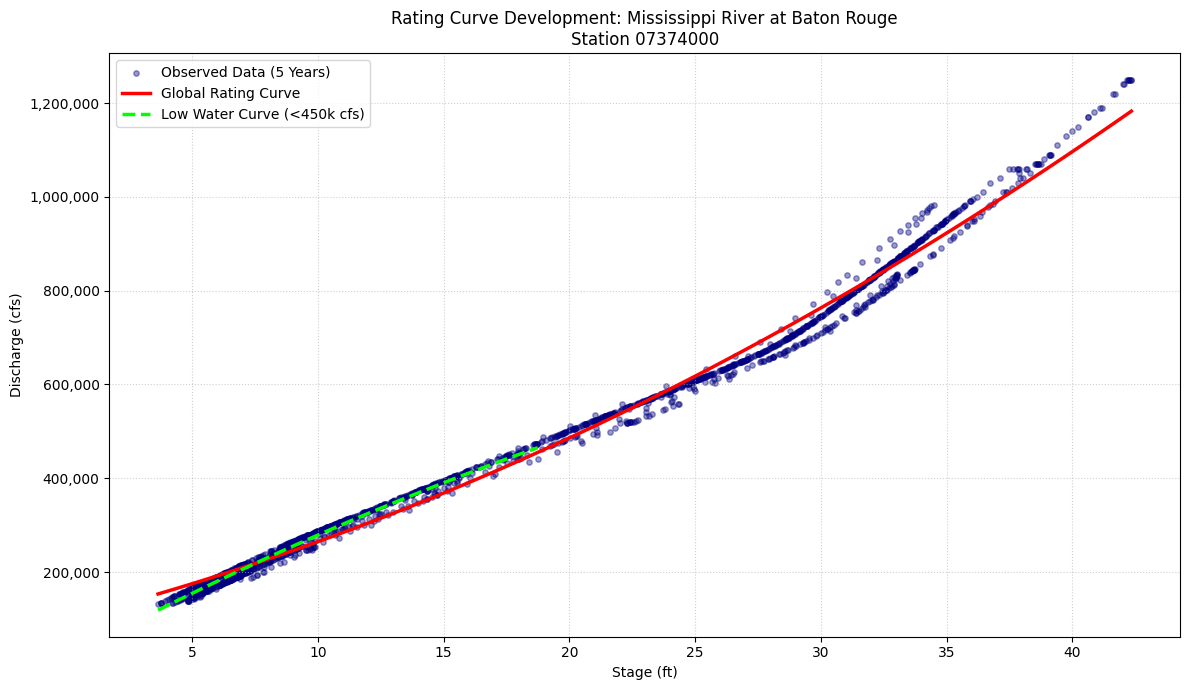

In [ ]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from datetime import datetime, timedelta

# --- Configuration ---
STATION_ID = "07374000"  # Mississippi River at Baton Rouge
YEARS_BACK = 5
DAYS_BACK = YEARS_BACK * 365

def get_usgs_daily_data(site_id, days_back, param_cd):
    """
    Fetches daily mean data for a specific parameter from USGS NWIS.
    param_cd: '00060' (Discharge) or '00065' (Gage Height)
    """
    url = "https://waterservices.usgs.gov/nwis/dv/?format=json"
    end_date = datetime.now()
    start_date = end_date - timedelta(days=days_back)

    params = {
        "sites": site_id,
        "startDT": start_date.strftime("%Y-%m-%d"),
        "endDT": end_date.strftime("%Y-%m-%d"),
        "parameterCd": param_cd,
        "statCd": "00003"  # Mean value
    }

    try:
        print(f"Fetching parameter {param_cd} for site {site_id}...")
        response = requests.get(url, params=params)
        response.raise_for_status()
        data = response.json()

        ts_data = []
        if 'value' in data and 'timeSeries' in data['value']:
            for ts in data['value']['timeSeries']:
                for item in ts['values'][0]['value']:
                    ts_data.append({
                        'Date': pd.to_datetime(item['dateTime']),
                        'Value': float(item['value'])
                    })

        df = pd.DataFrame(ts_data)
        if not df.empty:
            df.set_index('Date', inplace=True)
        return df

    except Exception as e:
        print(f"Error fetching param {param_cd}: {e}")
        return pd.DataFrame()

# --- 1. Acquire Data ---
# Get Discharge (Flow)
df_flow = get_usgs_daily_data(STATION_ID, DAYS_BACK, '00060')
df_flow.rename(columns={'Value': 'Flow_cfs'}, inplace=True)

# Get Gage Height (Stage)
df_stage = get_usgs_daily_data(STATION_ID, DAYS_BACK, '00065')
df_stage.rename(columns={'Value': 'Stage_ft'}, inplace=True)

# --- 2. Process & Analyze ---
if not df_flow.empty and not df_stage.empty:
    # Merge on Date index
    df_merged = pd.merge(df_stage, df_flow, left_index=True, right_index=True, how='inner')
    print(f"\nSuccessfully merged {len(df_merged)} daily records.")

    # Prepare vectors for regression (drop any remaining NaNs)
    df_clean = df_merged.dropna()
    x = df_clean['Stage_ft']
    y = df_clean['Flow_cfs']

    # --- Main Polynomial Regression (Degree 2) ---
    # Flow = a*Stage^2 + b*Stage + c
    coeffs = np.polyfit(x, y, 2)
    poly_eqn = np.poly1d(coeffs)

    print("\n--- Rating Curve Equation (All Data) ---")
    print(f"Flow = {coeffs[0]:.2f} * Stage^2 + {coeffs[1]:.2f} * Stage + {coeffs[2]:.2f}")

    # Generate regression line data
    x_line = np.linspace(x.min(), x.max(), 100)
    y_line = poly_eqn(x_line)

    # --- Low Water Regression (< 450,000 cfs) ---
    df_low = df_clean[df_clean['Flow_cfs'] < 450000]
    y_line_low = None

    if not df_low.empty:
        x_low = df_low['Stage_ft']
        y_low = df_low['Flow_cfs']

        coeffs_low = np.polyfit(x_low, y_low, 2)
        poly_eqn_low = np.poly1d(coeffs_low)

        print("\n--- Low Water Rating Curve Equation (< 450k cfs) ---")
        print(f"Flow = {coeffs_low[0]:.2f} * Stage^2 + {coeffs_low[1]:.2f} * Stage + {coeffs_low[2]:.2f}")

        # Generate line for plotting (within the range of low water data)
        x_line_low = np.linspace(x_low.min(), x_low.max(), 100)
        y_line_low = poly_eqn_low(x_line_low)
    else:
        print("\nNot enough low water data for specific regression.")

    # --- 3. Plotting ---
    plt.figure(figsize=(12, 7))

    # Scatter plot of observed data
    plt.scatter(df_clean['Stage_ft'], df_clean['Flow_cfs'],
                alpha=0.4, s=15, color='navy', label=f'Observed Data ({YEARS_BACK} Years)')

    # Plot Main Regression Line
    plt.plot(x_line, y_line, color='red', linewidth=2.5, label='Global Rating Curve')

    # Plot Low Water Regression Line
    if y_line_low is not None:
         plt.plot(x_line_low, y_line_low, color='lime', linestyle='--', linewidth=2.5, label='Low Water Curve (<450k cfs)')

    plt.title(f"Rating Curve Development: Mississippi River at Baton Rouge\nStation {STATION_ID}")
    plt.xlabel("Stage (ft)")
    plt.ylabel("Discharge (cfs)")
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.6)

    # Format Y axis
    plt.gca().get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

    plt.tight_layout()
    plt.show()

else:
    print("Error: Could not retrieve necessary data to build rating curve.")

Connecting to NWPS API for BTRL1...

--- NWPS DATA SUCCESS ---
                           Stage_ft  Flow_kcfs      Type  Flow_cfs
Timestamp                                                         
2026-02-24 12:00:00+00:00       7.9        182  Forecast  182000.0
2026-02-24 18:00:00+00:00       8.0        185  Forecast  185000.0
2026-02-25 00:00:00+00:00       8.0        185  Forecast  185000.0
2026-02-25 06:00:00+00:00       8.1        187  Forecast  187000.0
2026-02-25 12:00:00+00:00       8.1        187  Forecast  187000.0
2026-02-25 18:00:00+00:00       8.1        187  Forecast  187000.0
2026-02-26 00:00:00+00:00       8.1        187  Forecast  187000.0
2026-02-26 06:00:00+00:00       8.0        185  Forecast  185000.0
2026-02-26 12:00:00+00:00       8.0        185  Forecast  185000.0
2026-02-26 18:00:00+00:00       7.9        182  Forecast  182000.0

Saved to NWPS_BTRL1_Combined.csv

Calculating discharge using Low Water Rating Curve coefficients...


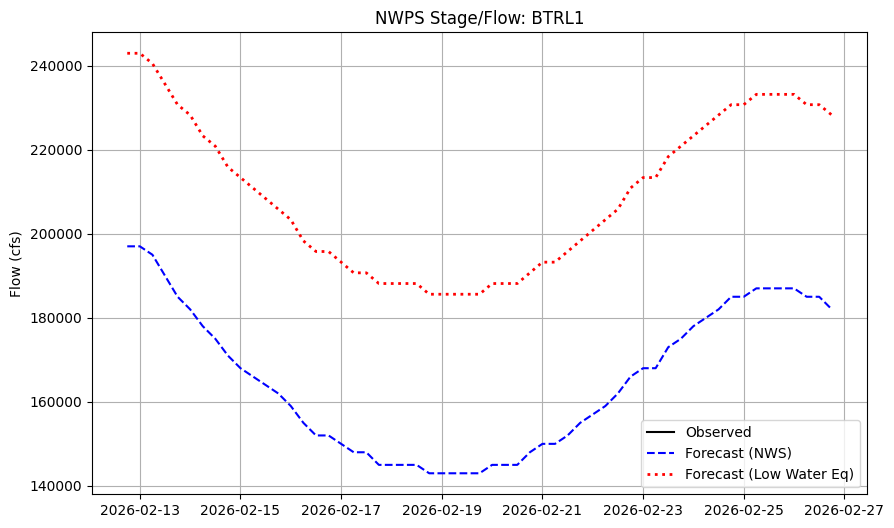

In [ ]:
import requests
import pandas as pd
from datetime import datetime

# --- CONFIGURATION ---
#STATION_ID = "BRLL1"  # Tarbert Landing (Flow)
STATION_ID = "BTRL1" # Red River Landing

def get_nwps_forecast(station_id="BRLL1"):
    # NEW 2025 ENDPOINT: National Water Prediction Service (NWPS)
    url = f"https://api.water.noaa.gov/nwps/v1/gauges/{station_id}/stageflow"

    # User-Agent is STRICTLY REQUIRED by the new API
    headers = {
        "User-Agent": "my-weather-script (contact@example.com)",
        "Accept": "application/json"
    }

    print(f"Connecting to NWPS API for {station_id}...")

    try:
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()

        data = response.json()

        # The new API returns separate blocks for "observation" and "forecast"
        # We want to combine them into one continuous timeline.

        # 1. Parse Forecast Data
        forecast_points = []
        if 'forecast' in data and 'data' in data['forecast']:
            for point in data['forecast']['data']:
                forecast_points.append({
                    'Timestamp': point.get('validTime'),
                    'Stage_ft': point.get('primary'),   # Primary usually Stage
                    'Flow_kcfs': point.get('secondary'), # Secondary usually Flow (kcfs)
                    'Type': 'Forecast'
                })

        # 2. Parse Observed Data (Past)
        observed_points = []
        if 'observation' in data and 'data' in data['observation']:
            for point in data['observation']['data']:
                observed_points.append({
                    'Timestamp': point.get('validTime'),
                    'Stage_ft': point.get('primary'),
                    'Flow_kcfs': point.get('secondary'),
                    'Type': 'Observed'
                })

        # Combine
        all_data = observed_points + forecast_points

        if not all_data:
            print("No data found in JSON response.")
            return None

        # 3. Create DataFrame
        df = pd.DataFrame(all_data)

        # Convert Timestamp
        df['Timestamp'] = pd.to_datetime(df['Timestamp'])
        df.set_index('Timestamp', inplace=True)
        df.sort_index(inplace=True)

        # Clean up units (NWPS often sends flow in kcfs, let's normalize to cfs)
        if 'Flow_kcfs' in df.columns:
            # Handle potential None values
            df['Flow_cfs'] = df['Flow_kcfs'].apply(lambda x: x * 1000.0 if pd.notnull(x) else None)

        return df

    except requests.exceptions.HTTPError as e:
        print(f"HTTP Error: {e}")
        # 404 means Station ID is wrong. 403 means User-Agent is missing.
    except Exception as e:
        print(f"General Error: {e}")
        return None

# --- EXECUTION ---
if __name__ == "__main__":
    df = get_nwps_forecast(STATION_ID)

    if df is not None:
        print("\n--- NWPS DATA SUCCESS ---")
        print(df.tail(10)) # Print the end (Forecast)

        # Save
        filename = f"NWPS_{STATION_ID}_Combined.csv"
        df.to_csv(filename)
        print(f"\nSaved to {filename}")

        # Filter just the Forecast part for your model
        df_forecast = df[df['Type'] == 'Forecast'].copy()

        # Plot
        try:
            import matplotlib.pyplot as plt

            plt.figure(figsize=(10,6))

            # Plot Observed
            df_obs = df[df['Type'] == 'Observed']
            plt.plot(df_obs.index, df_obs['Flow_cfs'], 'k-', label='Observed')

            # Plot Forecast (NWS)
            plt.plot(df_forecast.index, df_forecast['Flow_cfs'], 'b--', label='Forecast (NWS)')

            # --- Calculate and Plot Discharge using Low Water Rating Curve ---
            # Using the 'coeffs_low' variable from the previous cell
            if 'coeffs_low' in globals():
                print("\nCalculating discharge using Low Water Rating Curve coefficients...")
                # Ensure stage is numeric
                stages = df_forecast['Stage_ft'].astype(float)

                # Calculate Flow = a*Stage^2 + b*Stage + c
                # coeffs_low is [a, b, c]
                calc_flow = coeffs_low[0] * stages**2 + coeffs_low[1] * stages + coeffs_low[2]

                plt.plot(df_forecast.index, calc_flow, 'r:', linewidth=2, label='Forecast (Low Water Eq)')
            else:
                print("\nWarning: 'coeffs_low' not found. Ensure the rating curve cell was run.")

            plt.title(f"NWPS Stage/Flow: {STATION_ID}")
            plt.ylabel("Flow (cfs)")
            plt.legend()
            plt.grid(True)
            plt.show()
        except ImportError:
            pass
    else:
        print("Failed.")

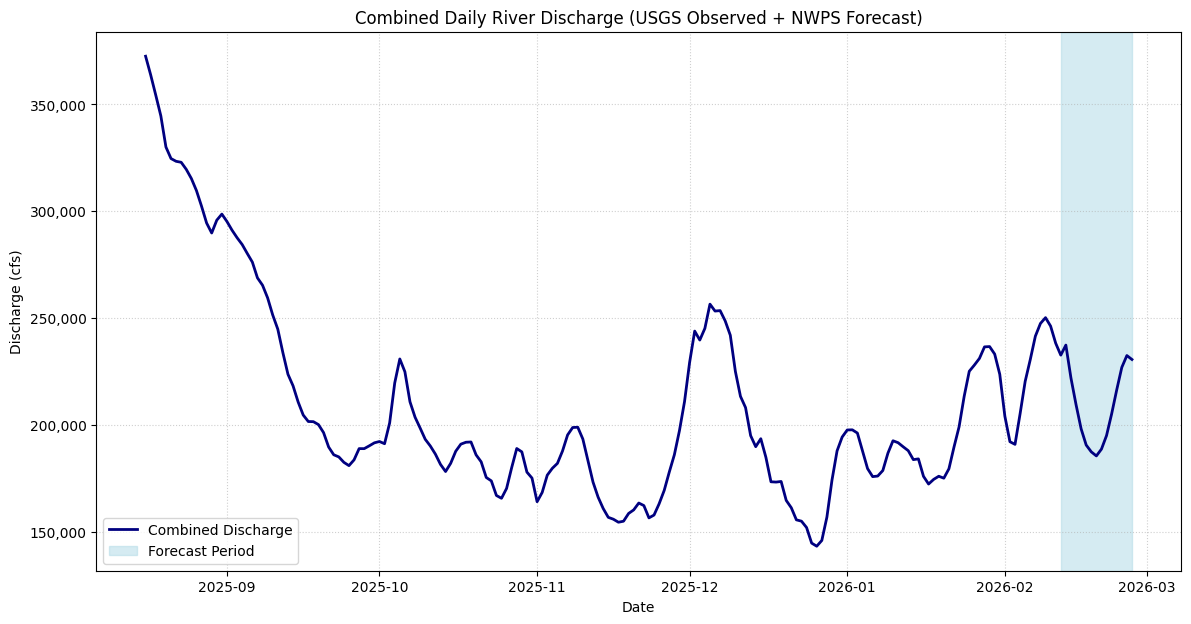

In [ ]:
# Check if data is available from previous steps
if 'usgs_df' in globals() and 'calc_flow' in globals():
    # 1. Prepare Observed Data (Daily Mean from USGS)
    obs_daily = usgs_df['Discharge_cfs'].resample('D').mean()

    # 2. Prepare Forecast Data (Daily Mean from NWPS calc_flow)
    # calc_flow is likely timezone-aware (UTC), while usgs_df is naive.
    # We must align them. Removing timezone from forecast is usually safest for plotting.
    forecast_series = calc_flow.copy()
    if forecast_series.index.tz is not None:
        forecast_series.index = forecast_series.index.tz_convert(None)

    forecast_daily = forecast_series.resample('D').mean()

    # 3. Combine Data
    # combine_first prioritizes the calling object (obs_daily) for overlapping indices
    combined_daily = obs_daily.combine_first(forecast_daily).sort_index()

    # 4. Plotting
    plt.figure(figsize=(14, 7))

    # Plot the combined series
    plt.plot(combined_daily.index, combined_daily, color='navy', linewidth=2, label='Combined Discharge')

    # Color the background for the forecasted period
    if not forecast_daily.empty:
        # Start shading from the first forecast date
        forecast_start = forecast_daily.index.min()
        plt.axvspan(forecast_start, combined_daily.index.max(),
                    color='lightblue', alpha=0.5, label='Forecast Period')

    plt.title(f"Combined Daily River Discharge (USGS Observed + NWPS Forecast)")
    plt.ylabel("Discharge (cfs)")
    plt.xlabel("Date")
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.6)

    # Format Y axis with commas
    import matplotlib.ticker as ticker
    plt.gca().get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

    plt.show()

else:
    print("Error: Necessary data ('usgs_df' or 'calc_flow') is missing. Please ensure previous cells have been executed successfully.")